In [1]:
import json

def load_coco_gt(gt_json_path):
    with open(gt_json_path, 'r') as f:
        gt_data = json.load(f)
    
    gt_dict = {}
    for ann in gt_data['annotations']:
        img_id = ann['image_id']
        
        bbox = ann['bbox']  # [x_min, y_min, width, height]
        bbox = [bbox[0],bbox[1],bbox[0]+bbox[2],bbox[1]+bbox[3]]
        category_id = ann['category_id']
        
        # COCO 형식의 bbox는 [x_min, y_min, width, height]
        if img_id not in gt_dict:
            gt_dict[img_id] = []
        gt_dict[img_id].append({
            'bbox': bbox,
            'category_id': category_id
        })
    
    return gt_dict


In [2]:
import csv
import numpy as np
def load_pascal_predictions(pred_csv_path):
    pred_dict = {}
    
    with open(pred_csv_path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            text = row['PredictionString'].split(" ")
            box_count = len(text)//6
            text = text[0:box_count*6]
            text = np.array(text).reshape(-1,6)
            img_id = int(row['image_id'].split("/")[1].split(".")[0])
            if img_id not in pred_dict:
                    pred_dict[img_id] = []
            for index in range(box_count):
                bbox = [float(text[index][2]),float(text[index][3]),float(text[index][4]),float(text[index][5])]
                score = float(text[index][1])
                category_id = int(text[index][0])                      
                pred_dict[img_id].append({
                    'bbox': bbox,
                    'score': score,
                    'category_id': category_id
                })
    
    return pred_dict


In [3]:
from tqdm import tqdm 

def calculate_iou(box1, box2):
    x_min1, y_min1, x_max1, y_max1 = box1
    x_min2, y_min2, x_max2, y_max2 = box2

    xi1 = max(x_min1, x_min2)
    yi1 = max(y_min1, y_min2)
    xi2 = min(x_max1, x_max2)
    yi2 = min(y_max1, y_max2)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x_max1 - x_min1) * (y_max1 - y_min1)
    box2_area = (x_max2 - x_min2) * (y_max2 - y_min2)

    union_area = box1_area + box2_area - inter_area
    iou = inter_area / union_area if union_area > 0 else 0
    
    return iou

def calculate_mAP(gt_dict, pred_dict, iou_threshold=0.5):
    tp, fp, fn = 0, 0, 0
    c = 0
    results = []  # 결과를 저장할 리스트

    for img_id, gt_boxes in tqdm(gt_dict.items()):
        pred_boxes = pred_dict.get(img_id, [])
        matched = []
        
        # GT와 예측 결과의 IOU 계산
        for gt in gt_boxes:
            c += 1
            max_iou = 0
            best_pred = None
            
            for pred in pred_boxes:
                iou = calculate_iou(gt['bbox'], pred['bbox'])
                if iou > max_iou:
                    max_iou = iou
                    best_pred = pred
            
            # 결과에 GT 정보 추가
            result = {
                'id': img_id,  # GT id
                'category_id': gt['category_id'],  # GT category_id
                'max_iou': max_iou,
                'box': gt['bbox']
            }
            results.append(result)
            
            if max_iou >= iou_threshold:
                tp += 1
                matched.append(best_pred)
            else:
                fn += 1
        
        # 매칭되지 않은 예측 결과는 FP
        for pred in pred_boxes:
            if pred not in matched:
                fp += 1
    print(tp,fn)
    precision = tp / (tp+fn) if c > 0 else 0
    recall = tp / c if c > 0 else 0
    mAP = precision  # 단일 IoU threshold에서는 precision이 mAP와 동일
    
    return mAP, results  # mAP와 결과 리스트를 반환


In [4]:
gt_dict = load_coco_gt('train.json')
pred_dict = load_pascal_predictions('ATSS_swinl_fpn_train_tta_0.05.csv')

mAP50, results = calculate_mAP(gt_dict, pred_dict, iou_threshold=0.85)
print(f'mAP50: {mAP50:.4f}')

100%|██████████| 4883/4883 [00:03<00:00, 1563.44it/s]

10853 12291
mAP50: 0.4689


In [5]:
import pandas as pd    
df_results = pd.DataFrame(results)

    # CSV 파일로 저장
df_results.to_csv('results.csv', index=False) 

In [13]:
import pandas as pd
import ast

# IOU 계산 함수
def calculate_iou(box1, box2):
    x_min1, y_min1, x_max1, y_max1 = box1
    x_min2, y_min2, x_max2, y_max2 = box2

    xi1 = max(x_min1, x_min2)
    yi1 = max(y_min1, y_min2)
    xi2 = min(x_max1, x_max2)
    yi2 = min(y_max1, y_max2)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x_max1 - x_min1) * (y_max1 - y_min1)
    box2_area = (x_max2 - x_min2) * (y_max2 - y_min2)

    union_area = box1_area + box2_area - inter_area
    iou = inter_area / union_area if union_area > 0 else 0
    
    return iou

# AP 계산 함수
def calculate_ap(results, iou_threshold=0.85):
    tp = sum(1 for res in results if res['max_iou'] >= iou_threshold)
    fn = sum(1 for res in results if res['max_iou'] < iou_threshold)
    fp = len(results) - tp  # 모든 예측에서 TP를 뺀 나머지는 FP로 간주
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    #print(precision,recall)
    return precision, recall, tp, fp

# CSV 파일 읽기
df_results =  pd.read_csv('results.csv')
# 'box' 열을 문자열에서 리스트로 변환
df_results['box'] = df_results['box'].apply(ast.literal_eval)

# max_iou가 0.5 이상인 항목 필터링
filtered_results = df_results[df_results['max_iou'] >= 0.0].to_dict(orient='records')

# 클래스별 AP 계산
class_ap = {}
for category_id in pd.Series(df_results['category_id']).unique():
    class_results = [res for res in filtered_results if res['category_id'] == category_id]
    ap, recall, tp, fp = calculate_ap(class_results)
    class_ap[category_id] = {'AP': ap, 'Recall': recall, 'TP': tp, 'FP': fp}

# 클래스별 크기 비율 AP 계산
class_size_ratios_ap = {category_id: {} for category_id in pd.Series(df_results['category_id']).unique()}

# 박스 크기 비율에 따른 AP 계산
size_ratios = {
    '1:4': [],
    '1:2': [],
    '1:1': [],
    '2:1': [],
    '4:1': []
}

# 박스 크기 비율에 따라 분류
for row in filtered_results:
    width, height = row['box'][2] - row['box'][0], row['box'][3] - row['box'][1]
    aspect_ratio = width / height if height > 0 else float('inf')

    if aspect_ratio < 0.25:  # 1:4 비율
        size_ratios['1:4'].append(row)
    elif aspect_ratio < 0.5:  # 1:2 비율
        size_ratios['1:2'].append(row)
    elif aspect_ratio < 2:  # 1:1 비율
        size_ratios['1:1'].append(row)
    elif aspect_ratio < 4:  # 2:1 비율
        size_ratios['2:1'].append(row)
    else:  # 4:1 비율
        size_ratios['4:1'].append(row)

# 클래스별로 크기 비율 AP 계산
for category_id in class_size_ratios_ap.keys():
    for ratio, results in size_ratios.items():
        class_results = [res for res in results if res['category_id'] == category_id]
        ap, recall, tp, fp = calculate_ap(class_results)
        class_size_ratios_ap[category_id][ratio] = {'AP': ap, 'Recall': recall, 'TP': tp, 'FP': fp}

# 클래스별 이미지 사이즈 AP 계산
class_image_size_ap = {category_id: {} for category_id in pd.Series(df_results['category_id']).unique()}




# 크기 비율별 AP 계산
size_ap = {}
for ratio, results in size_ratios.items():
    ap, recall, tp, fp = calculate_ap(results)
    size_ap[ratio] = {'AP': ap, 'Recall': recall, 'TP': tp, 'FP': fp}

size_classes = {
    '96x96': [],
    '64x64': [],
    '32x32': [],
    '16x16': [],
    '8x8': []
}


# 박스 크기 기준으로 분류
for row in filtered_results:
    width, height = row['box'][2] - row['box'][0], row['box'][3] - row['box'][1]
    
    if width >= 96 and height >= 96:  # 96x32 단위
        size_classes['96x96'].append(row)
    elif width >= 64 and height >= 64:  # 64x24 단위
        size_classes['64x64'].append(row)
    elif width >= 32 and height >= 32:  # 32x12 단위
        size_classes['32x32'].append(row)
    elif width >= 16 and height >= 16:  # 16x8 단위
        size_classes['16x16'].append(row)
    else:  # 8x3 단위
        size_classes['8x8'].append(row)

# 이미지 크기별 AP 계산
image_size_ap = {}
for size, results in size_classes.items():
    ap, recall, tp, fp = calculate_ap(results)
    image_size_ap[size] = {'AP': ap, 'Recall': recall, 'TP': tp, 'FP': fp}
# 클래스별 이미지 사이즈 AP 계산
for category_id in class_image_size_ap.keys():
    for size, results in size_classes.items():
        class_results = [res for res in results if res['category_id'] == category_id]
        ap, recall, tp, fp = calculate_ap(class_results)
        class_image_size_ap[category_id][size] = {'AP': ap, 'Recall': recall, 'TP': tp, 'FP': fp}
# 결과 출력
print("클래스별 AP:")
for category_id, metrics in sorted(class_ap.items()):
    print(f"Category ID: {category_id}, AP: {metrics['AP']:.4f}, Recall: {metrics['Recall']:.4f}")

print("\n크기 비율별 AP:")
for ratio, metrics in size_ap.items():
    print(f"Size Ratio: {ratio}, AP: {metrics['AP']:.4f}, Recall: {metrics['Recall']:.4f}")

print("\n이미지 사이즈별 AP:")
for size, metrics in image_size_ap.items():
    print(f"Image Size: {size}, AP: {metrics['AP']:.4f}, Recall: {metrics['Recall']:.4f}")

# 결과 출력
print("클래스별 크기 비율 AP:")
for category_id, ratios in sorted(class_size_ratios_ap.items()):
    print(f"\nCategory ID: {category_id}")
    for ratio, metrics in ratios.items():
        print(f"  Size Ratio: {ratio}, AP: {metrics['AP']:.4f}, Recall: {metrics['Recall']:.4f}")

print("\n클래스별 이미지 사이즈 AP:")
for category_id, sizes in sorted(class_image_size_ap.items()):
    print(f"\nCategory ID: {category_id}")
    for size, metrics in sizes.items():
        print(f"  Image Size: {size}, AP: {metrics['AP']:.4f}, Recall: {metrics['Recall']:.4f}")



클래스별 AP:
Category ID: 0, AP: 0.4375, Recall: 0.4375
Category ID: 1, AP: 0.3539, Recall: 0.3539
Category ID: 2, AP: 0.6388, Recall: 0.6388
Category ID: 3, AP: 0.6026, Recall: 0.6026
Category ID: 4, AP: 0.4511, Recall: 0.4511
Category ID: 5, AP: 0.4642, Recall: 0.4642
Category ID: 6, AP: 0.4450, Recall: 0.4450
Category ID: 7, AP: 0.5713, Recall: 0.5713
Category ID: 8, AP: 0.6415, Recall: 0.6415
Category ID: 9, AP: 0.6453, Recall: 0.6453

크기 비율별 AP:
Size Ratio: 1:4, AP: 0.2068, Recall: 0.2068
Size Ratio: 1:2, AP: 0.3999, Recall: 0.3999
Size Ratio: 1:1, AP: 0.5270, Recall: 0.5270
Size Ratio: 2:1, AP: 0.2748, Recall: 0.2748
Size Ratio: 4:1, AP: 0.0751, Recall: 0.0751

이미지 사이즈별 AP:
Image Size: 96x96, AP: 0.6042, Recall: 0.6042
Image Size: 64x64, AP: 0.2985, Recall: 0.2985
Image Size: 32x32, AP: 0.1715, Recall: 0.1715
Image Size: 16x16, AP: 0.0335, Recall: 0.0335
Image Size: 8x8, AP: 0.0000, Recall: 0.0000
클래스별 크기 비율 AP:

Category ID: 0
  Size Ratio: 1:4, AP: 0.1667, Recall: 0.1667
  Size Rat

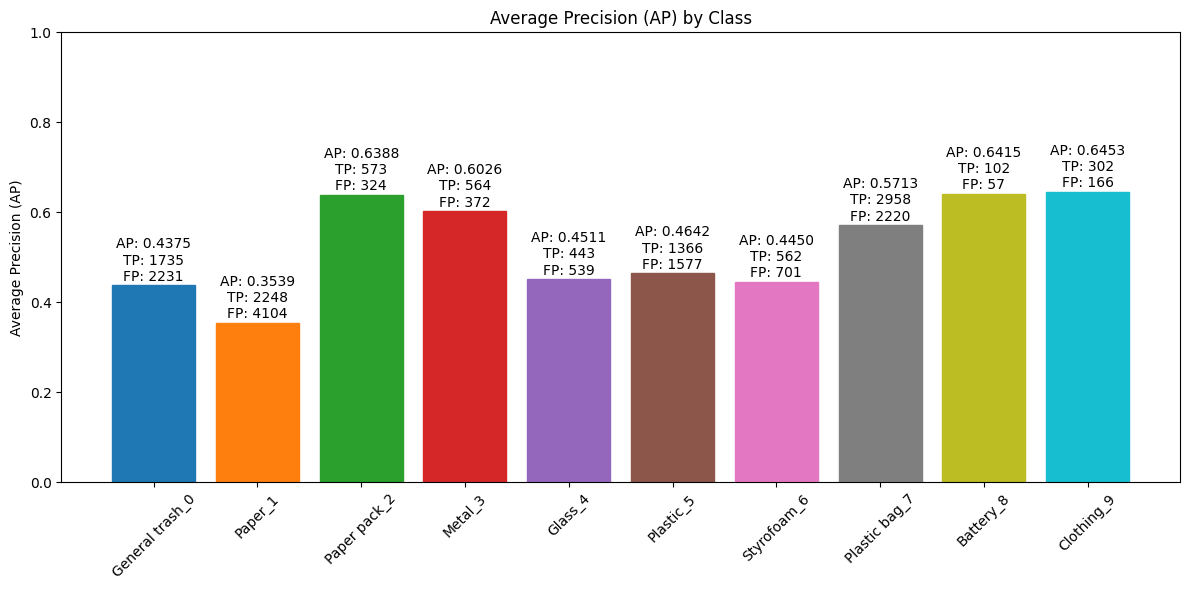

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# 클래스 ID와 이름의 매핑
class_names = {
    0: "General trash",
    1: "Paper",
    2: "Paper pack",
    3: "Metal",
    4: "Glass",
    5: "Plastic",
    6: "Styrofoam",
    7: "Plastic bag",
    8: "Battery",
    9: "Clothing"
}

# 클래스별 AP와 색상 설정
categories = sorted(class_ap.keys())
ap_values = [class_ap[cat]['AP'] for cat in categories]
tp_values = [class_ap[cat]['TP'] for cat in categories]
fp_values = [class_ap[cat]['FP'] for cat in categories]
colors = plt.cm.tab10(np.linspace(0, 1, len(categories)))

# 시각화
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(categories)), ap_values, color=colors)
plt.xticks(range(len(categories)), [f"{class_names[category_id]}_{category_id}" for category_id in categories], rotation=45)
plt.ylabel("Average Precision (AP)")
plt.title("Average Precision (AP) by Class")
plt.ylim(0, 1)

# 바에 색상 추가
for bar, color in zip(bars, colors):
    bar.set_color(color)

# AP, TP, FP 레이블 추가
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"AP: {height:.4f}\nTP: {tp_values[i]}\nFP: {fp_values[i]}", ha='center')

plt.tight_layout()
plt.show()


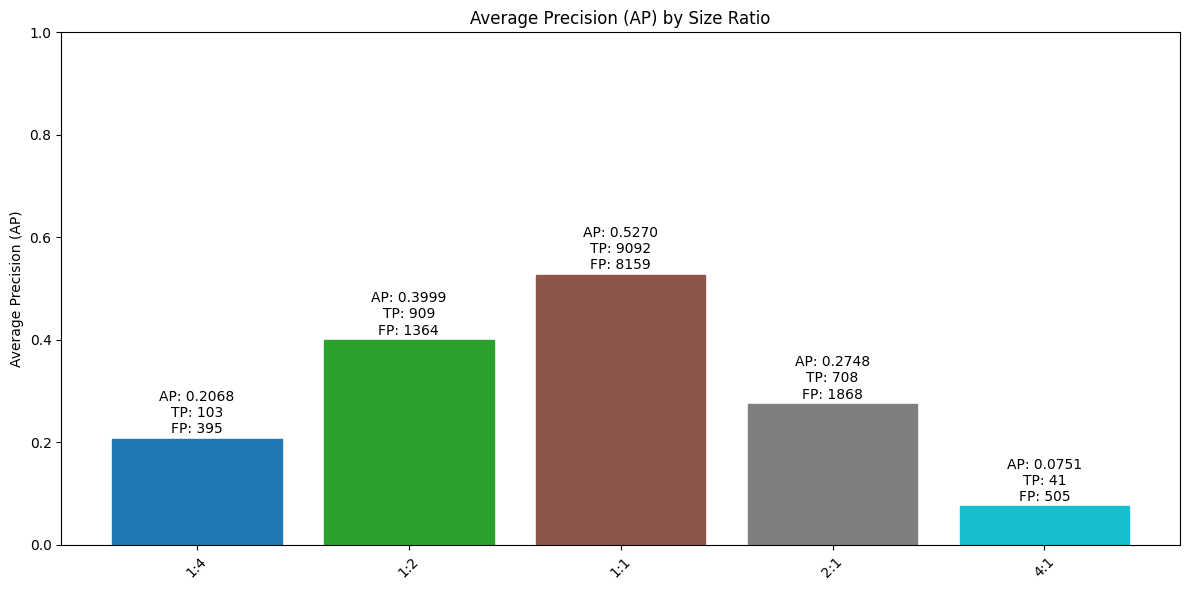

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# 크기 비율과 AP, TP, FP 값
size_ratios = list(size_ap.keys())
ap_values_size = [size_ap[ratio]['AP'] for ratio in size_ratios]
tp_values_size = [size_ap[ratio]['TP'] for ratio in size_ratios]
fp_values_size = [size_ap[ratio]['FP'] for ratio in size_ratios]
colors_size = plt.cm.tab10(np.linspace(0, 1, len(size_ratios)))

# 시각화
plt.figure(figsize=(12, 6))
bars_size = plt.bar(range(len(size_ratios)), ap_values_size, color=colors_size)
plt.xticks(range(len(size_ratios)), size_ratios, rotation=45)
plt.ylabel("Average Precision (AP)")
plt.title("Average Precision (AP) by Size Ratio")
plt.ylim(0, 1)

# 바에 색상 추가
for bar, color in zip(bars_size, colors_size):
    bar.set_color(color)

# AP, TP, FP 레이블 추가
for i, bar in enumerate(bars_size):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
             f"AP: {height:.4f}\nTP: {tp_values_size[i]}\nFP: {fp_values_size[i]}", 
             ha='center')

plt.tight_layout()
plt.show()


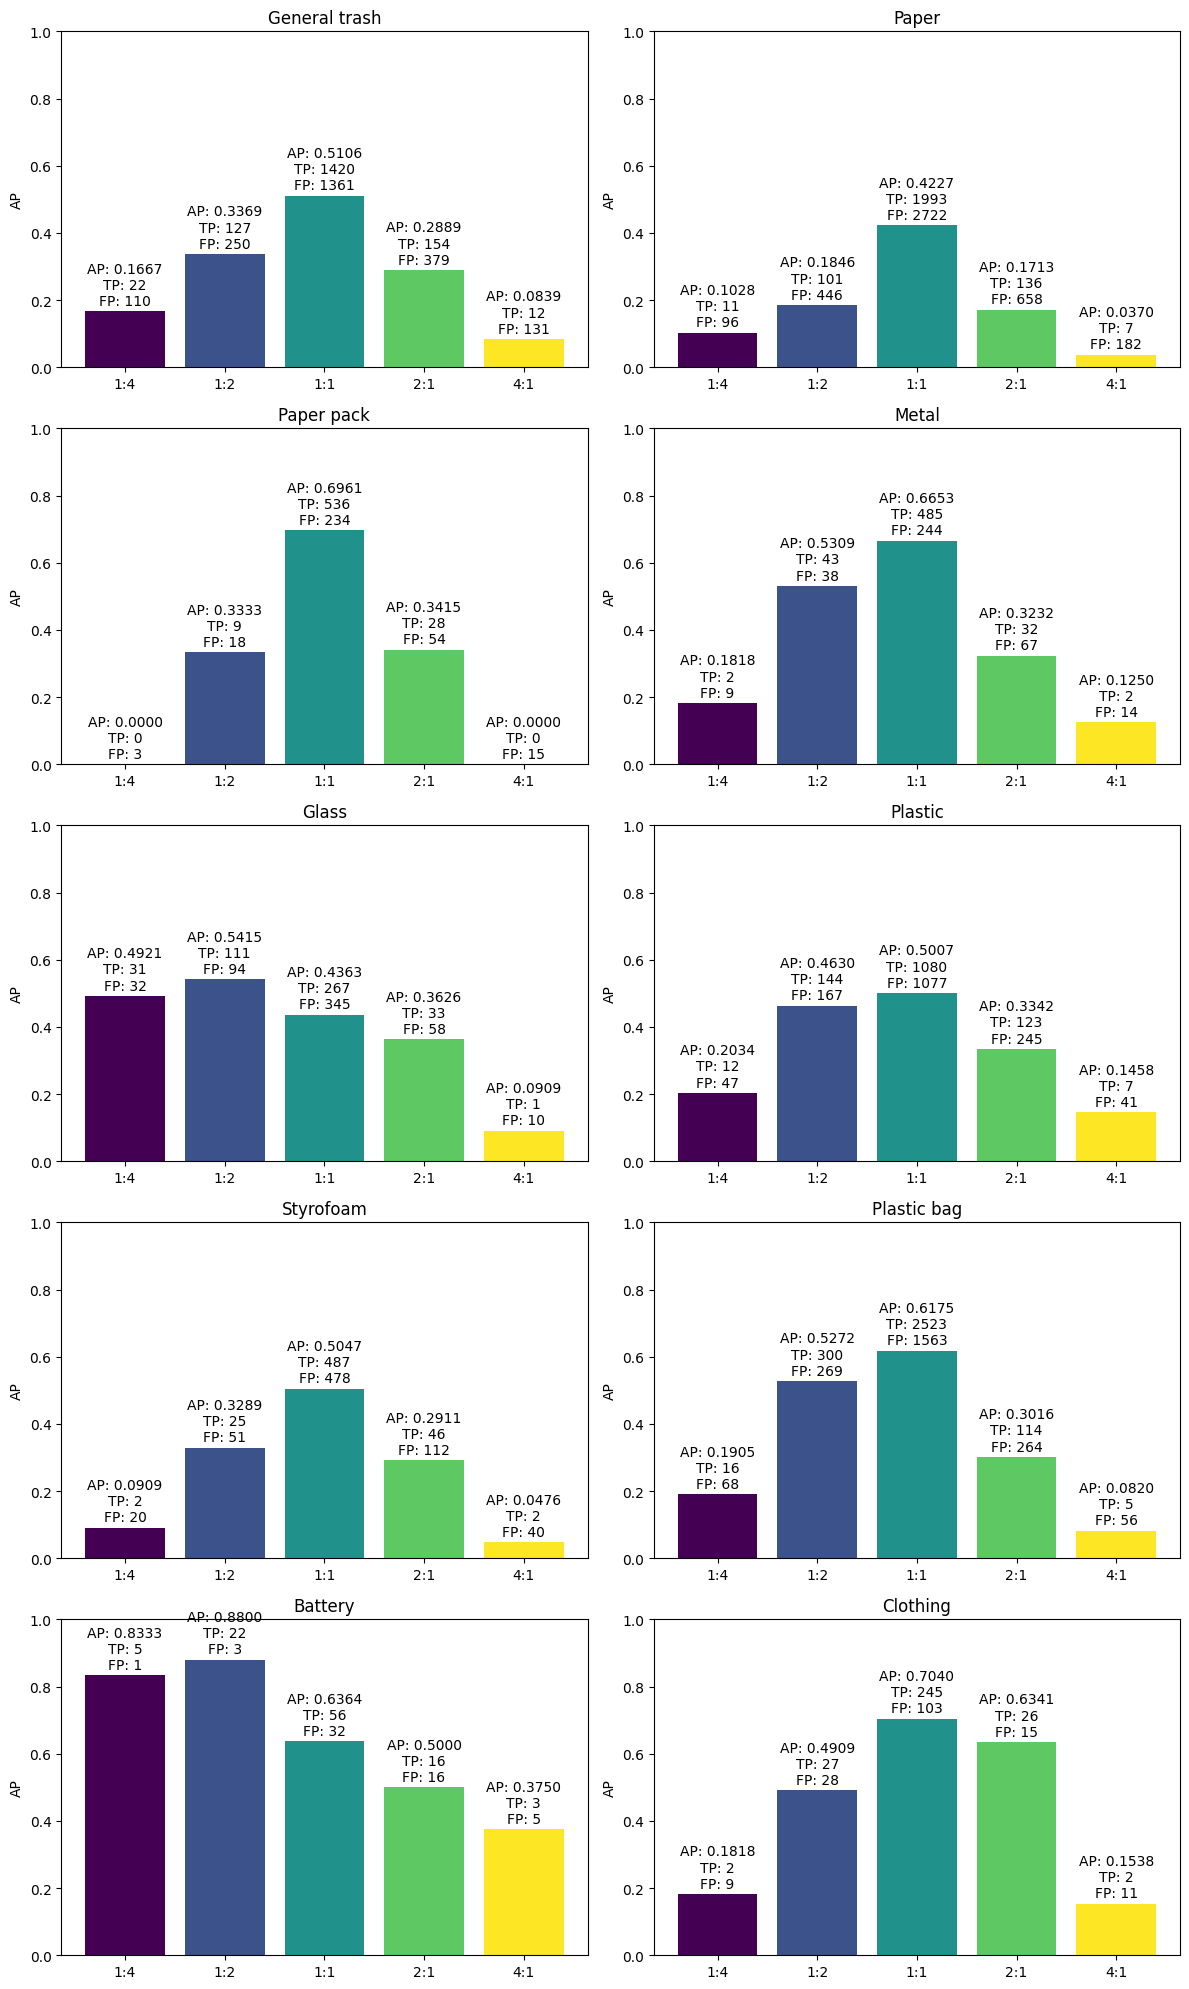

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# 클래스별 크기 비율 AP 데이터
class_size_ratios = {category_id: metrics for category_id, metrics in class_size_ratios_ap.items()}

# 비율별 색상 정의
size_ratios = ['1:4', '1:2', '1:1', '2:1', '4:1']
colors = plt.cm.viridis(np.linspace(0, 1, len(size_ratios)))  # 비율별 색상

# 카테고리 ID와 이름 매핑
category_names = {
    0: "General trash",
    1: "Paper",
    2: "Paper pack",
    3: "Metal",
    4: "Glass",
    5: "Plastic",
    6: "Styrofoam",
    7: "Plastic bag",
    8: "Battery",
    9: "Clothing"
}

# 시각화
num_rows = 5
num_cols = 2
plt.figure(figsize=(12, 20))

for i, (category_id, ratios) in enumerate(sorted(class_size_ratios.items())):
    ap_values = [ratios[ratio]['AP'] for ratio in size_ratios]
    tp_values = [ratios[ratio]['TP'] for ratio in size_ratios]
    fp_values = [ratios[ratio]['FP'] for ratio in size_ratios]
    
    ax = plt.subplot(num_rows, num_cols, i + 1)
    bars = ax.bar(size_ratios, ap_values, color=colors)  # 세로 막대 그래프
    ax.set_ylim(0, 1)
    ax.set_ylabel("AP")
    ax.set_title(category_names[category_id])  # 카테고리 이름으로 제목 설정

    # 막대 위에 AP, TP, FP 레이블 추가
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
                f"AP: {height:.4f}\nTP: {tp_values[j]}\nFP: {fp_values[j]}", 
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


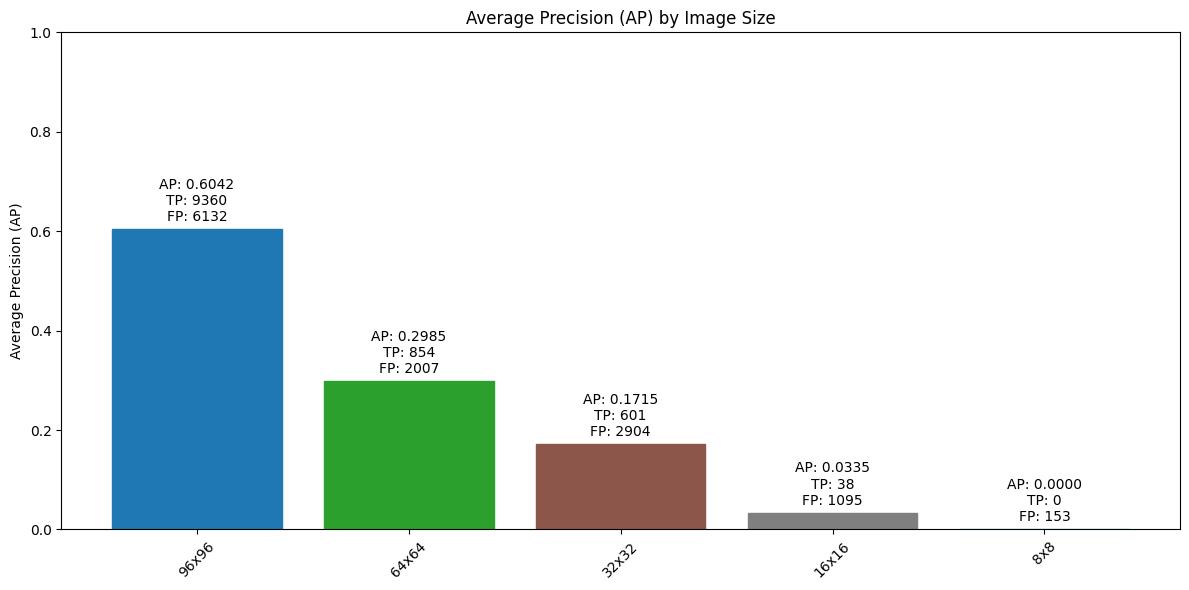

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지 크기와 AP 값
image_sizes = list(image_size_ap.keys())
ap_values_image = [image_size_ap[size]['AP'] for size in image_sizes]
tp_values_image = [image_size_ap[size]['TP'] for size in image_sizes]
fp_values_image = [image_size_ap[size]['FP'] for size in image_sizes]
colors_image = plt.cm.tab10(np.linspace(0, 1, len(image_sizes)))

# 시각화
plt.figure(figsize=(12, 6))
bars_image = plt.bar(range(len(image_sizes)), ap_values_image, color=colors_image)
plt.xticks(range(len(image_sizes)), image_sizes, rotation=45)
plt.ylabel("Average Precision (AP)")
plt.title("Average Precision (AP) by Image Size")
plt.ylim(0, 1)

# 바에 색상 추가
for bar, color in zip(bars_image, colors_image):
    bar.set_color(color)

# 레이블 추가 (AP, TP, FP)
for i, bar in enumerate(bars_image):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
             f"AP: {height:.4f}\nTP: {tp_values_image[i]}\nFP: {fp_values_image[i]}", 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()


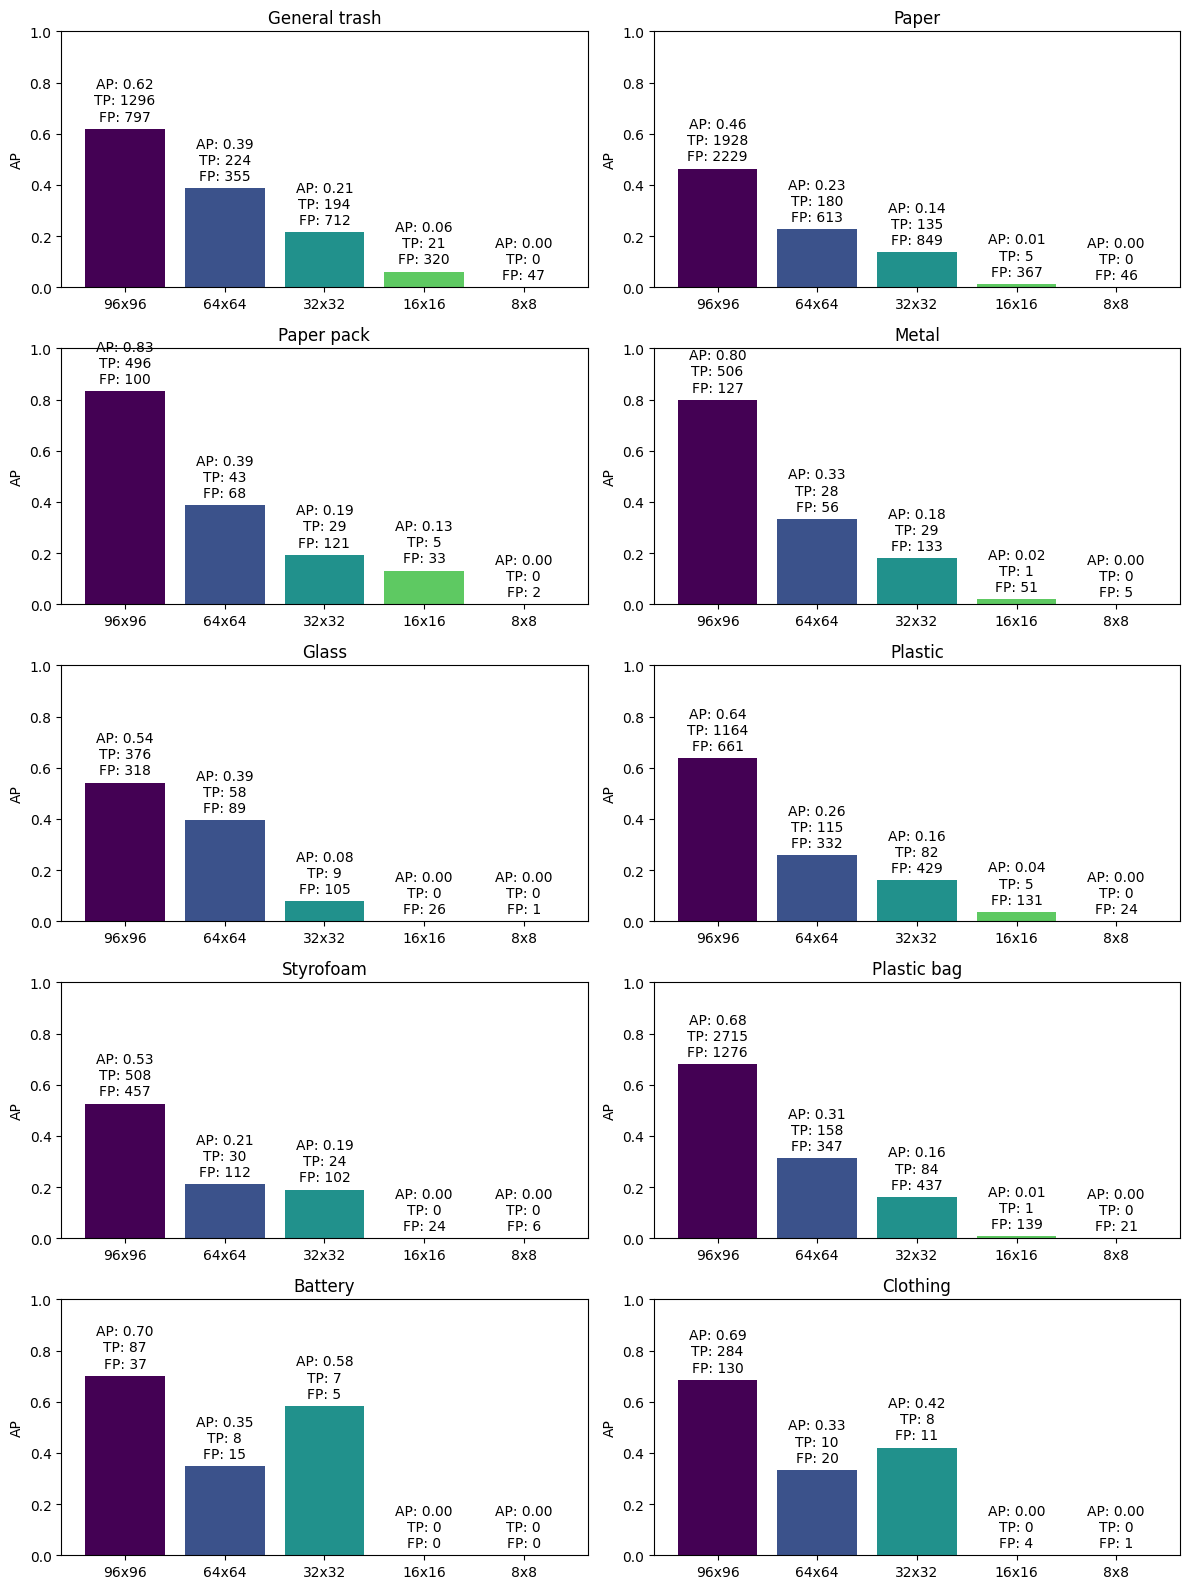

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# 클래스별 이미지 사이즈 AP 데이터
class_image_size_ap = {category_id: metrics for category_id, metrics in class_image_size_ap.items()}

# 이미지 크기 정의
image_sizes = ['96x96', '64x64', '32x32', '16x16', '8x8']
colors = plt.cm.viridis(np.linspace(0, 1, len(image_sizes)))  # 이미지 크기별 색상

# 카테고리 ID와 이름 매핑
category_names = {
    0: "General trash",
    1: "Paper",
    2: "Paper pack",
    3: "Metal",
    4: "Glass",
    5: "Plastic",
    6: "Styrofoam",
    7: "Plastic bag",
    8: "Battery",
    9: "Clothing"
}

# 시각화
num_rows = 5
num_cols = 2
plt.figure(figsize=(12, 16))
for i, (category_id, sizes) in enumerate(sorted(class_image_size_ap.items())):
    ap_values = [sizes[size]['AP'] for size in image_sizes]
    tp_values = [sizes[size]['TP'] for size in image_sizes]
    fp_values = [sizes[size]['FP'] for size in image_sizes]
    
    ax = plt.subplot(num_rows, num_cols, i + 1)
    bars = ax.bar(image_sizes, ap_values, color=colors)  # 세로 막대 그래프
    ax.set_ylim(0, 1)
    ax.set_ylabel("AP")
    ax.set_title(category_names[category_id])  # 카테고리 이름으로 제목 설정
    
    # 막대 위에 AP, TP, FP 값 표시
    for j, bar in enumerate(bars):
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, 
                f"AP: {yval:.2f}\nTP: {tp_values[j]}\nFP: {fp_values[j]}", 
                ha='center', va='bottom')

plt.tight_layout()
plt.show()
